# Computing the variational free energy (VFE) in categorical models

Tutorial from **pymdp** package documentation https://pymdp-rtd.readthedocs.io/en/latest/notebooks/free_energy_calculation.html

In [1]:
! pip install inferactively-pymdp

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Latex

from pymdp import utils, maths

import autograd.numpy as np_auto   # Thinly-wrapped version of Numpy that is auto-differentiable
from autograd import grad          # this is the function that we use to evaluate derivatives
from functools import partial

#### Helper functions

In [3]:
## Define a quick helper function for printing arrays nicely 
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

### Generative model composed of a likelihood and a prior

In this example there are two possible observations and two possible hidden states.

The generative model is composed of two distributions: a likelihood distribution $P(o|s)$ and a prior distribution $P(s)$.

In [6]:
num_obs = 2 # dimensionality of observations (2 possible observation levels)

num_states = 2 # dimensionality of observations (2 possible hidden state levels)

observation = 1 # Example of an observation

prior = np.array([0.5, 0.5]) 

likelihood_dist = np.array([ [0.2, 0.8],
                        [0.8, 0.2] ])

if isinstance(observation, np.ndarray):
    print(f'Observation:{observation}\n')
else:
    print(f'Observation: {observation}\n')
print(f'Prior:{prior}\n')
print('Likelihood:')
matprint(likelihood_dist)

Observation: 1

Prior:[0.5 0.5]

Likelihood:
0.2  0.8  
0.8  0.2  


### Exact Bayesian Inference

Now we will find the optimal posterior over hidden states given the observation $o = o_1$ using exact bayesian inference (i.e. Bayes rule)

$ \hspace{60mm} \Large P(s | o _1) = \frac{P(o_1 | s)P(s)}{P(o_1)} = \frac{P(o_1,s)}{P(o_1)}$

#### 1. Get the likelihood over hidden states, given the observation $P(o = o_1 | s)$

In [10]:
likelihood_s = likelihood_dist[observation,:] 

print(likelihood_s)

[0.8 0.2]


#### 2. Compute the joint probability $P(o_1,s)$

In [12]:
joint_prob = likelihood_s * prior

print(joint_prob)

[0.4 0.1]


#### 3. Compute Marginal probability or marginal likelihood: $P(o_1) =\sum_s P(o_1, s) $

In [19]:
p_1 = joint_prob.sum()

print(p_1)

0.5


#### 4. Compute the posterior:

In [20]:
posterior = joint_prob / p_1 # divide the joint by the marginal

print(f'Posterior over hidden states: {posterior}')
print('==================')

Posterior over hidden states: [0.8 0.2]


## Variational Free Energy 

The variational free energy is an upper bound on surprise. 

By minimizing free energy, we are minimizing surprise and thus maximizing log evidence. 

In [21]:
surprise = - np.log(p_1)

display(Latex(f'$- \ln P(o_1)$:'))
print(f'Surprise: {surprise.round(3)}')
print('==================')

<IPython.core.display.Latex object>

Surprise: 0.693


In [31]:
# to begin with, set our initial Q(s) equal to our prior distribution -- i.e. a flat/uninformative belief about hidden states
qs = np.array([0.5, 0.5])

# redefine generative model and observation, for ease
observation = 1
likelihood_dist = np.array([[0.2, 0.8], [0.8, 0.2]])
prior = [0.5,0.5]

# compute the joint or generative model using the factorization: P(o=o1|s)P(s)
joint_prob = likelihood_dist[observation,:] * prior

# compute the variational free energy using the expected log difference formulation
initial_F = qs.dot(np.log(qs) - np.log(joint_prob))

print(f'Variational free energy (F) = {initial_F.round(3)}')
print('==================')

Variational free energy (F) = 0.916


## Gradient descent on VFE

In [34]:
# define the variational free energy as a function of the approximate posterior, an observation, and the generative model
def vfe(qs, obs, likelihood, prior):
    """
    Quick docstring below on inputs
    Arguments:
    =========
    `qs` [1D np_auto.ndarray]: variational posterior over hidden states
    `obs` [int]: index of the observation
    `likelihood` [2D np_auto.ndarray]: likelihood distribution P(o|s), relating hidden states probabilistically to observations
    `prior` [1D np_auto.ndarray]: prior over hidden states
    """

    likelihood_s = likelihood[obs,:]

    joint = likelihood_s * prior

    vfe = qs @ (np_auto.log(qs) - np_auto.log(joint))

    return vfe

# initialize an observation, an initial variational posterior, a prior, and a likelihood matrix
obs = 1
init_qs = np_auto.array([0.5, 0.5])
prior = np_auto.array([0.5, 0.5])
likelihood_dist = np_auto.array([ [0.2, 0.8],
                        [0.8, 0.2] ])

# this use of `partial` creates a version of the vfe function that is a function of Qs only, 
# with the other parameters (the observation, the generative model) fixed as constant parameters
vfe_qs = partial(vfe, obs = obs, likelihood = likelihood_dist, prior = prior)

# By calling `grad` on a function, we get out a function that can be used to compute the gradients of the VFE 
# with respect to its input (in our case, `qs`)
grad_vfe_qs = grad(vfe_qs)

$ \Large \hspace{60mm} Q(s)_{t+1} = Q(s)_{t} - \frac{\partial \mathcal{F}}{\partial Q(s)_{t}} $

In [37]:
# number of iterations of gradient descent to perform
n_iter = 40

qs_hist = np_auto.zeros((n_iter, 2))
qs_hist[0,:] = init_qs

vfe_hist = np_auto.zeros(n_iter)
vfe_hist[0] = vfe_qs(qs = init_qs)

learning_rate = 0.1 # learning rate to prevent gradient steps that are too big (overshooting)

for i in range(n_iter-1):   

    dFdqs = grad_vfe_qs(qs_hist[i,:])

    ln_qs = np_auto.log(qs_hist[i,:]) - learning_rate * dFdqs # transform qs to log-space to perform gradient descent
    qs_hist[i+1,:] = maths.softmax(ln_qs) # re-normalize to make it a proper, categorical Q(s) again

    vfe_hist[i+1] = vfe_qs(qs = qs_hist[i+1,:]) # measure final variational free energy

Text(0.5, 1.0, 'Gradient descent on VFE')

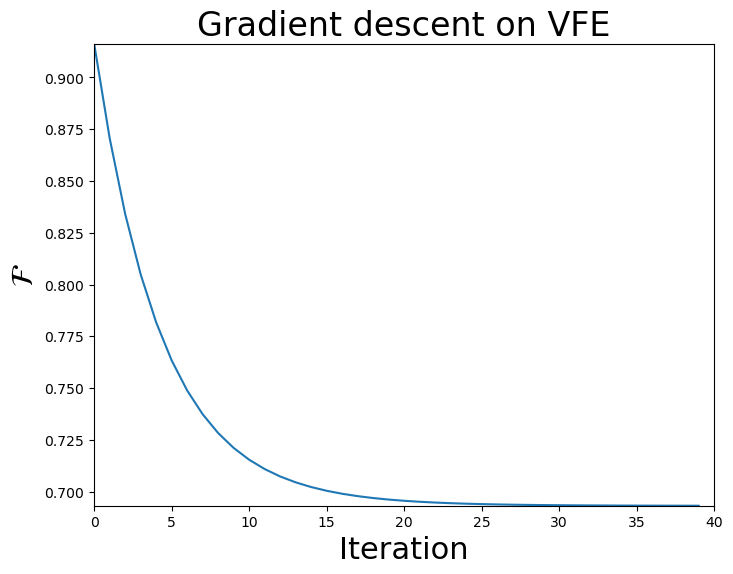

In [38]:
fig = plt.figure(figsize=(8,6))
plt.plot(vfe_hist)
plt.ylabel('$\\mathcal{F}$', fontsize = 22)
plt.xlabel("Iteration", fontsize = 22)
plt.xlim(0, n_iter)
plt.ylim(vfe_hist[-1], vfe_hist[0])
plt.title('Gradient descent on VFE', fontsize = 24)